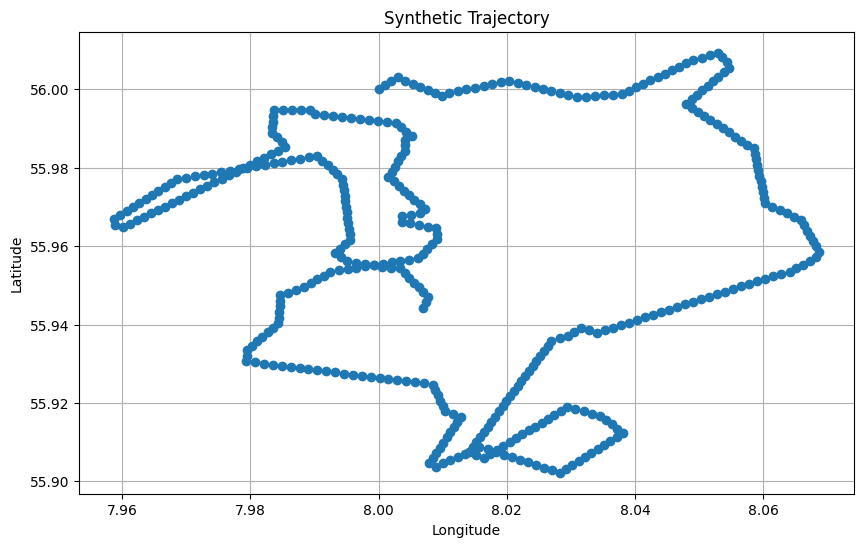

In [1]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import random, math

class SyntheticTrajectoryGenerator:
    def __init__(
            self,
            start_lat: float = 56.0,
            start_lng: float = 8.0,
            start_timestamp: int = None,
            step_seconds: int = 60,
            num_points: int = 20,
            delta_lat: float = 0.001,
            delta_lng: float = 0.001,
            noise: float = 0.0,
            jitter_time: bool = False,
            seed: int = None,
    ):
        if seed is not None:
            random.seed(seed)
        self.start_lat = start_lat
        self.start_lng = start_lng
        self.step_seconds = step_seconds
        self.num_points = num_points
        self.delta_lat = delta_lat
        self.delta_lng = delta_lng
        self.noise = noise
        self.jitter_time = jitter_time

        if start_timestamp is None:
            import datetime

            start_timestamp = int(
                datetime.datetime.now(datetime.timezone.utc).timestamp()
            )
        self.start_timestamp = start_timestamp

    def generate(self) -> List[Tuple[float, float, int]]:
        lat, lng = self.start_lat, self.start_lng
        timestamp = self.start_timestamp

        trajectory = []

        num_turns = random.randint(1, self.num_points // 5)

        turning_points = sorted(random.sample(range(2, self.num_points - 2), num_turns))

        delta_lat = self.delta_lat
        delta_lng = self.delta_lng

        for i in range(self.num_points):
            # Apply turning point by changing direction randomly
            if i in turning_points:
                angle = random.uniform(-1.5, 1.5)  # radians
                cos_a = math.cos(angle)
                sin_a = math.sin(angle)
                new_delta_lat = cos_a * delta_lat - sin_a * delta_lng
                new_delta_lng = sin_a * delta_lat + cos_a * delta_lng
                delta_lat, delta_lng = new_delta_lat, new_delta_lng

            # Add noise and jitter
            noise_lat = random.uniform(-self.noise, self.noise)
            noise_lng = random.uniform(-self.noise, self.noise)
            time_offset = random.randint(-5, 5) if self.jitter_time else 0

            trajectory.append(
                (lng + noise_lng, lat + noise_lat, timestamp + time_offset)
            )

            lat += delta_lat
            lng += delta_lng
            timestamp += self.step_seconds

        return trajectory


generator = SyntheticTrajectoryGenerator(
    start_lat=56.0,
    start_lng=8.0,
    start_timestamp=None,
    step_seconds=60,
    num_points=400,
    delta_lat=0.001,
    delta_lng=0.001,
    noise=0.0,
    jitter_time=False,
    seed=None
)

trajectory = generator.generate()
plt.figure(figsize=(10, 6))
lngs, lats, timestamps = zip(*trajectory)
plt.plot(lngs, lats, marker='o')
plt.title("Synthetic Trajectory")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()


In [3]:


Trajectory = List[Tuple[float, float, int]]  # (longitude, latitude, timestamp in seconds)

import utm
from typing import List, Tuple
from torch.utils.data import Dataset

from encoder import (
    trajectory_to_time_annotated_utm_trajectory,
    time_annotated_utm_trajectory_to_trajectory
)

Trajectory = List[Tuple[float, float, int]]  # (longitude, latitude, timestamp in seconds)


class TrajectoryDataset(Dataset):
    def __init__(self, trajectories: List[Trajectory], max_length: int, stride: int):
        self.max_length = max_length
        self.stride = stride

        # Compute UTM conversion parameters based on the first trajectory
        self.center_lat = sum(lat for _, lat, _ in trajectories[0]) / len(trajectories[0])
        self.center_lng = sum(lng for lng, _, _ in trajectories[0]) / len(trajectories[0])
        _, _, self.zone_number, self.zone_letter = utm.from_latlon(self.center_lat, self.center_lng)

        # Create a list of (subtrajectory, full original trajectory index)
        self.windows = []

        for i, traj in enumerate(trajectories):
            utm_traj = trajectory_to_time_annotated_utm_trajectory(
                traj, self.center_lat, self.center_lng, self.zone_number, self.zone_letter
            )
            for start in range(0, len(utm_traj) - self.max_length + 1, self.stride):
                subtraj = utm_traj[start: start + self.max_length]
                self.windows.append(subtraj)

    def decode(self, tensor):
        return time_annotated_utm_trajectory_to_trajectory(
            tensor, self.center_lat, self.center_lng, self.zone_number, self.zone_letter
        )

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        return self.windows[idx]

tensor([[-1.9656e+00,  3.9766e+00,  6.6667e-01,  3.9130e-01,  8.1356e-01,
          0.0000e+00],
        [-1.9496e+00,  4.0042e+00,  6.6667e-01,  3.9130e-01,  8.3051e-01,
          1.6667e-02],
        [-1.9336e+00,  4.0318e+00,  6.6667e-01,  3.9130e-01,  8.4746e-01,
          3.3333e-02],
        [-1.9176e+00,  4.0594e+00,  6.6667e-01,  3.9130e-01,  8.6441e-01,
          5.0000e-02],
        [-1.9016e+00,  4.0870e+00,  6.6667e-01,  3.9130e-01,  8.8136e-01,
          6.6667e-02],
        [-1.8856e+00,  4.1146e+00,  6.6667e-01,  3.9130e-01,  8.9831e-01,
          8.3333e-02],
        [-1.8696e+00,  4.1422e+00,  6.6667e-01,  3.9130e-01,  9.1525e-01,
          1.0000e-01],
        [-1.8536e+00,  4.1698e+00,  6.6667e-01,  3.9130e-01,  9.3220e-01,
          1.1667e-01],
        [-1.8377e+00,  4.1974e+00,  6.6667e-01,  3.9130e-01,  9.4915e-01,
          1.3333e-01],
        [-1.8217e+00,  4.2250e+00,  6.6667e-01,  3.9130e-01,  9.6610e-01,
          1.5000e-01],
        [-1.8057e+00,  4.2526e

/tmp/ipykernel_9368/115679571.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  traj_tensor = torch.tensor(traj, dtype=torch.float32)


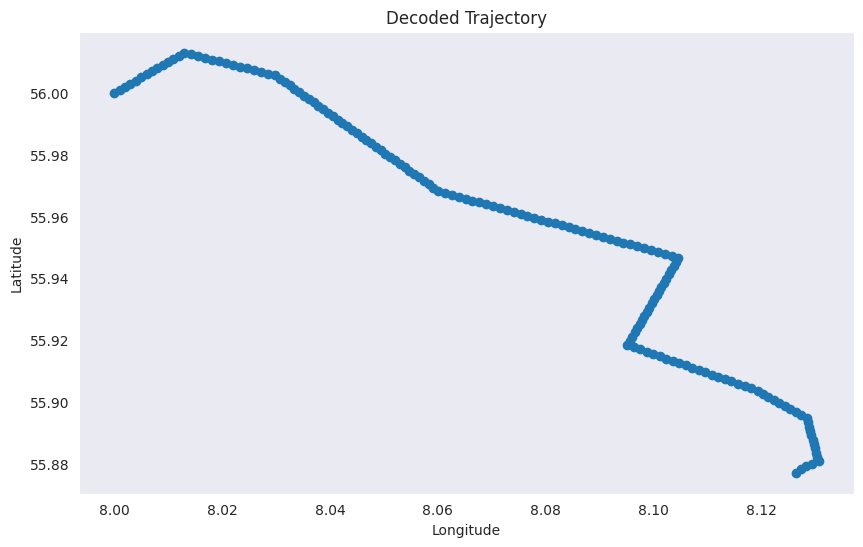

In [3]:

import torch

dataset = TrajectoryDataset(
    [
        generator.generate()  # Generate synthetic trajectory
        for _ in range(1000)  # Generate 100 synthetic trajectories
    ]

    , max_length=160, stride=120)  # allow small overlap
batch_size = 32
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

print(dataset[0][0])
# We decode the first trajectory to make sure it corresponds to the original synthetic trajectory
traj = dataset.decode(dataset[0][0])
plt.figure(figsize=(10, 6))
lngs, lats, timestamps = zip(*traj)
plt.plot(lngs, lats, marker='o')
plt.title("Decoded Trajectory")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()

In [15]:
import torch
from torch import nn

# Check and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dimension = 6  # (easting, northing, timestamp)
embedding_dim = 64
epochs = 1000


# Define encoder and decoder

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(input_dimension, embedding_dim)
        self.decoder = nn.Linear(embedding_dim, input_dimension)

    def forward(self, x):
        z = self.encoder(x)  # (B, T, embedding_dim)
        out = self.decoder(z)  # (B, T, input_dimension)
        return out


# Instantiate model and move to device
model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

model.train()

for epoch in range(epochs):
    total_loss = 0
    for i, (inputs, targets) in enumerate(data_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        reconstructed = model(inputs)
        loss = criterion(reconstructed, targets)
        loss.backward()

        if i % 10 == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1} - Loss: {avg_loss:.6f}")


Using device: cuda


/tmp/ipykernel_9368/115679571.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  traj_tensor = torch.tensor(traj, dtype=torch.float32)


Epoch 1 - Loss: 7.634806
Epoch 2 - Loss: 4.833356
Epoch 3 - Loss: 2.885116
Epoch 4 - Loss: 1.632910
Epoch 5 - Loss: 0.869534
Epoch 6 - Loss: 0.456925
Epoch 7 - Loss: 0.264467
Epoch 8 - Loss: 0.184207
Epoch 9 - Loss: 0.145954
Epoch 10 - Loss: 0.118737
Epoch 11 - Loss: 0.097715
Epoch 12 - Loss: 0.081510
Epoch 13 - Loss: 0.069314
Epoch 14 - Loss: 0.059525
Epoch 15 - Loss: 0.051837
Epoch 16 - Loss: 0.045521
Epoch 17 - Loss: 0.040450
Epoch 18 - Loss: 0.036143
Epoch 19 - Loss: 0.032606
Epoch 20 - Loss: 0.029508
Epoch 21 - Loss: 0.026823
Epoch 22 - Loss: 0.024442
Epoch 23 - Loss: 0.022356
Epoch 24 - Loss: 0.020422
Epoch 25 - Loss: 0.018707
Epoch 26 - Loss: 0.017144
Epoch 27 - Loss: 0.015726
Epoch 28 - Loss: 0.014440
Epoch 29 - Loss: 0.013261
Epoch 30 - Loss: 0.012207
Epoch 31 - Loss: 0.011239
Epoch 32 - Loss: 0.010369
Epoch 33 - Loss: 0.009589
Epoch 34 - Loss: 0.008869
Epoch 35 - Loss: 0.008219
Epoch 36 - Loss: 0.007638
Epoch 37 - Loss: 0.007103
Epoch 38 - Loss: 0.006622
Epoch 39 - Loss: 0.00

KeyboardInterrupt: 

[(-1.9657227993011475, 3.9744162559509277, 0.6648926734924316, 0.39124611020088196, 0.8136821985244751, -0.0006798207759857178), (-1.9497287273406982, 4.0020318031311035, 0.6648872494697571, 0.39124631881713867, 0.8306319713592529, 0.01599186658859253), (-1.9337353706359863, 4.0296478271484375, 0.6648820638656616, 0.39124637842178345, 0.8475818634033203, 0.032663702964782715), (-1.9177427291870117, 4.0572638511657715, 0.6648768782615662, 0.3912467360496521, 0.8645315170288086, 0.04933544993400574), (-1.9017510414123535, 4.084880352020264, 0.6648714542388916, 0.3912467360496521, 0.8814812898635864, 0.06600725650787354), (-1.885759949684143, 4.1124958992004395, 0.6648662090301514, 0.3912469744682312, 0.8984311819076538, 0.08267894387245178), (-1.8697699308395386, 4.14011287689209, 0.6648610830307007, 0.3912471532821655, 0.9153810739517212, 0.09935067594051361), (-1.853780746459961, 4.16772985458374, 0.6648557782173157, 0.3912472724914551, 0.932330846786499, 0.11602246761322021), (-1.8377

/tmp/ipykernel_9368/115679571.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  traj_tensor = torch.tensor(traj, dtype=torch.float32)
/tmp/ipykernel_9368/2337862689.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_batch = torch.tensor(input_tensor, dtype=torch.float32).unsqueeze(0).to(device)


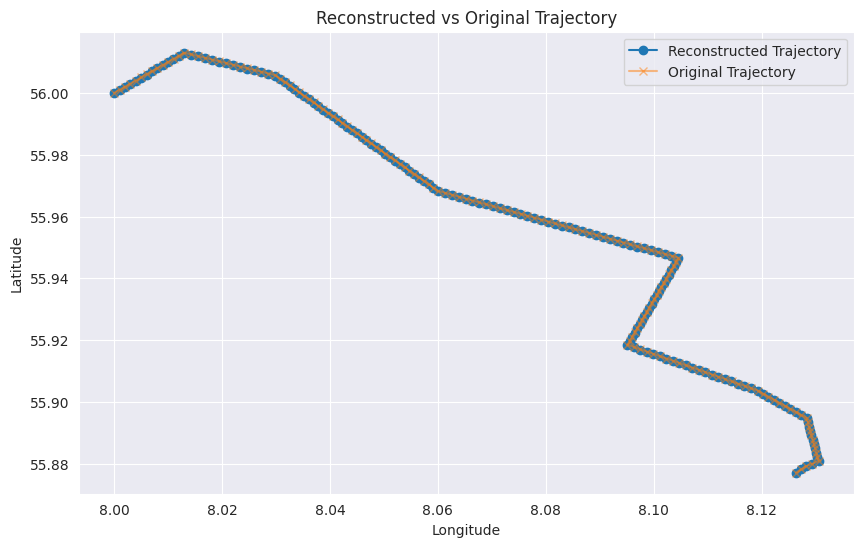

In [16]:
from torch import Tensor

# Put model in eval mode
model.eval()

# Get first input from dataset
input_tensor, _ = dataset[0]  # shape: (T, input_dim)

# Add batch dimension and convert to float tensor
input_batch = torch.tensor(input_tensor, dtype=torch.float32).unsqueeze(0).to(device)

# Forward pass through model (no grad needed)
with torch.no_grad():
    reconstructed = model(input_batch)  # shape (1, T, input_dim)

# Remove batch dim and convert to list of tuples
reconstructed = reconstructed.squeeze(0).tolist()
reconstructed_tuples = [tuple(timestep) for timestep in reconstructed]

print(reconstructed_tuples)
# Decode from UTM back to lat/lon/time
decoded_trajectory = dataset.decode(Tensor(reconstructed))
decoded_original = dataset.decode(input_tensor)
print(decoded_trajectory)

plt.figure(figsize=(10, 6))
lngs, lats, timestamps = zip(*decoded_trajectory)
plt.plot(lngs, lats, marker='o', label='Reconstructed Trajectory')
lngs_orig, lats_orig, timestamps_orig = zip(*decoded_original)
plt.plot(lngs_orig, lats_orig, marker='x', label='Original Trajectory', alpha=0.5)
plt.title("Reconstructed vs Original Trajectory")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

